# Electricity Consumption in Slovenia

In this notebook, we will explore the properties of electricity consumption in Slovenia. The aim is to perform basic analytics on the data and build a linear regression model to forecast electricity consumption.


In [1]:
# Installing required libraries
%pip install pandas	
%pip install matplotlib
%pip install scikit-learn
%pip install statsmodels
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import necessary libraries
import pandas as pd # type: ignore

file_path = r'D:\Projects\Programming\Gen-I Trading Challenge\Task 1\datasets\original\Data_SLO.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path,sep=';',parse_dates=['ProductStartUTC','ProductStartCET'])
df = df.sort_values(by='ProductStartUTC')
# Display the first few rows of the dataset
df.head()


,ProductStartUTC,ProductStartCET,Temperature,Consumption
0,2022-12-31 23:00:00,2023-01-01 00:00:00,12.250000,836.0
1,2023-01-01 00:00:00,2023-01-01 01:00:00,12.183333,829.0
2,2023-01-01 01:00:00,2023-01-01 02:00:00,12.100000,794.0
3,2023-01-01 02:00:00,2023-01-01 03:00:00,12.266667,760.0
4,2023-01-01 03:00:00,2023-01-01 04:00:00,12.116667,739.0


In [4]:
# Basic info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15911 entries, 0 to 15910
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ProductStartUTC  15911 non-null  datetime64[ns]
 1   ProductStartCET  15911 non-null  datetime64[ns]
 2   Temperature      15869 non-null  float64       
 3   Consumption      15868 non-null  float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 497.3 KB


In [5]:
# Summary statistics
df.describe()

,ProductStartUTC,ProductStartCET,Temperature,Consumption
count,15911,15911,15869.000000,15868.000000
mean,2023-11-28 10:00:00,2023-11-28 11:38:27.158569728,13.389378,1237.458029
min,2022-12-31 23:00:00,2023-01-01 00:00:00,-9.433333,0.000000
25%,2023-06-15 16:30:00,2023-06-15 18:30:00,7.283333,1029.000000
50%,2023-11-28 10:00:00,2023-11-28 11:00:00,13.433333,1217.000000
75%,2024-05-12 03:30:00,2024-05-12 05:30:00,19.616667,1440.000000
max,2024-10-24 21:00:00,2024-10-24 23:00:00,34.983333,2171.000000
std,NaN,NaN,8.487222,300.663196


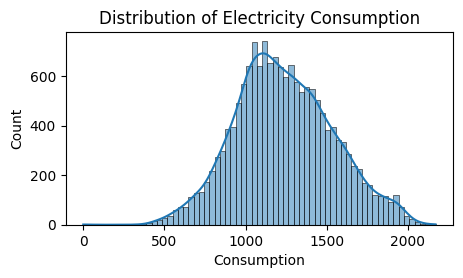

In [6]:
# Import libraries for visualization
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

# Plot histogram for electricity consumption
plt.figure(figsize=(5, 2.5))
sns.histplot(df['Consumption'], kde=True)
plt.title('Distribution of Electricity Consumption')
plt.show()

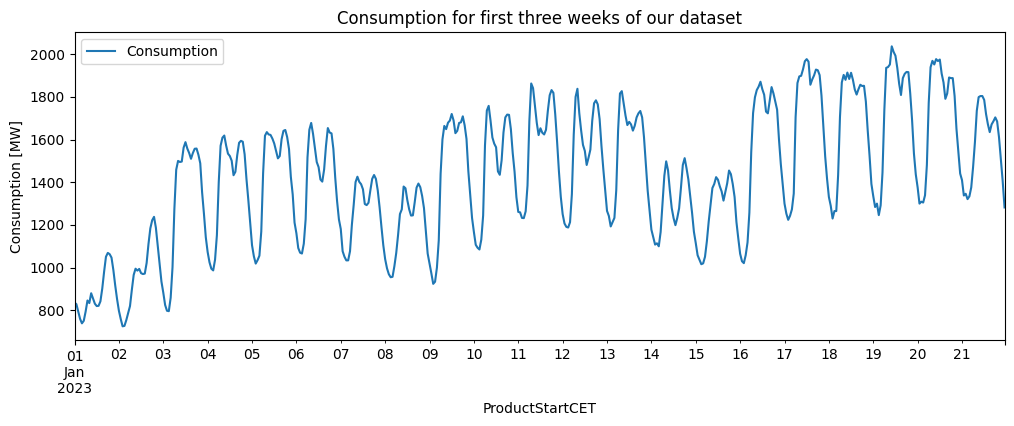

In [7]:
#How does timeseries look like for first three weeks of year 2023
df.head(168*3).plot(x='ProductStartCET',y='Consumption',title='Consumption for first three weeks of our dataset',figsize =(12,4))
plt.ylabel('Consumption [MW]')

# Show the plot
plt.show()

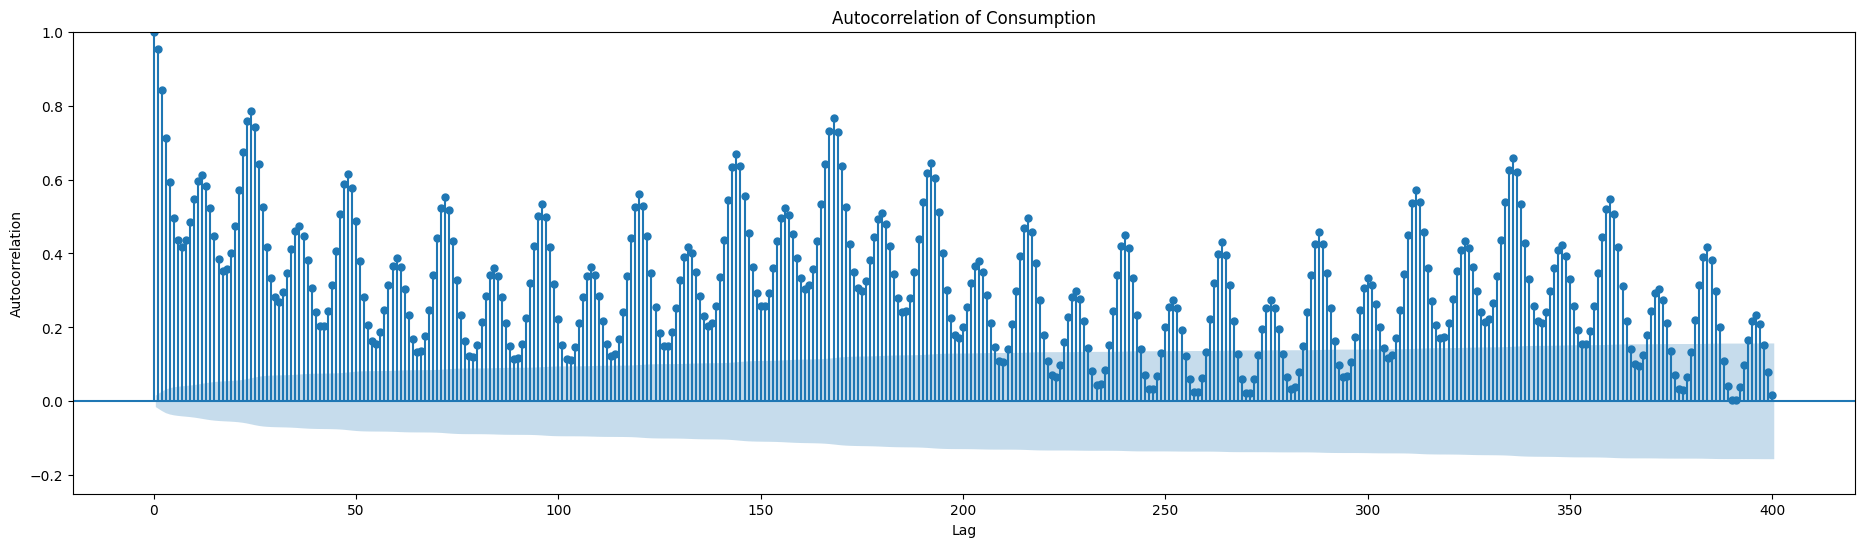

In [8]:
#autocorellation
from statsmodels.graphics.tsaplots import plot_acf # type: ignore

# Set figure size to make it wider
fig = plt.figure(figsize=(23, 6))  # Adjust the width as needed
ax = fig.add_subplot(111)

# Plot autocorrelation for the 'Consumption' column with 400 lags
plot_acf(df.ffill()['Consumption'], lags=400,ax=ax)
plt.title('Autocorrelation of Consumption')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.ylim(-0.25, 1)
plt.show()

# Use Day-7 Consumption as forecast (value from 1 week before)

C:\Users\patri\AppData\Local\Temp\ipykernel_15432\251993190.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df_hourly.asfreq('H')


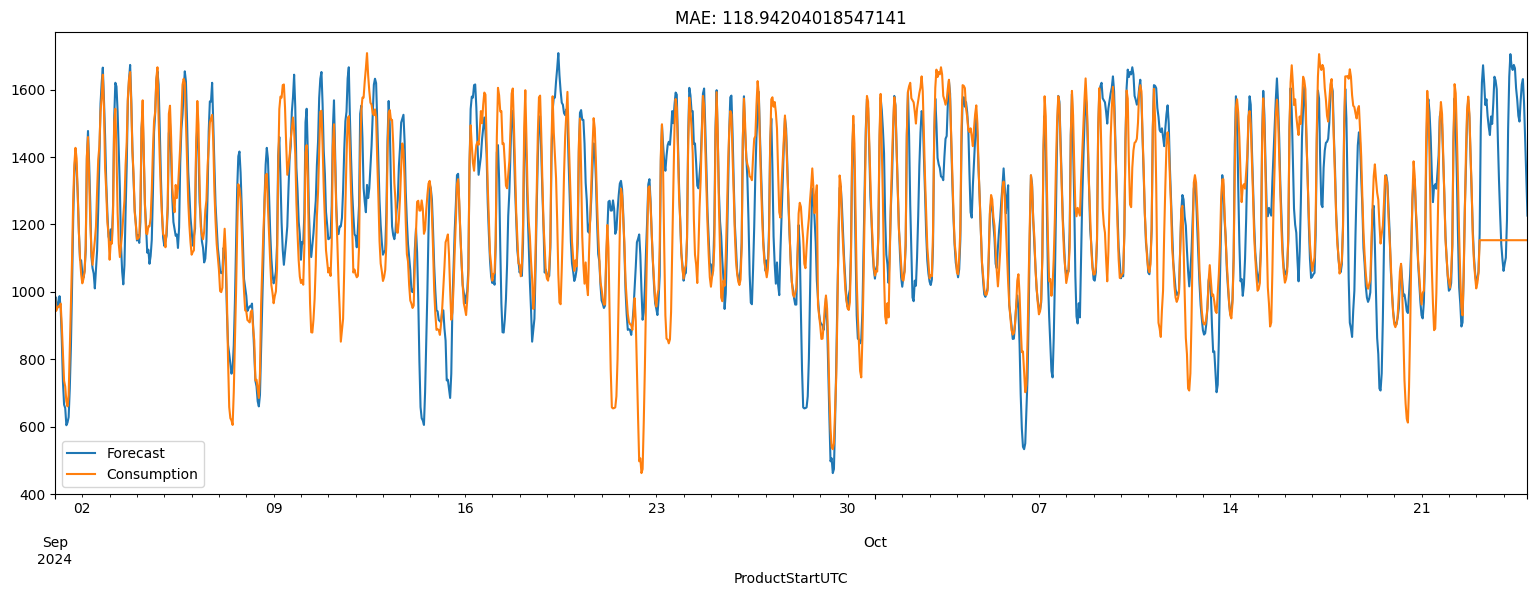

In [9]:
df_hourly=df.set_index('ProductStartUTC')
df_hourly = df_hourly.asfreq('H')
df_hourly.ffill(inplace=True)

#in porduciton we can not use 24 hour lag for all products, so we use 168 lag (1 week)
df_hourly['ShiftedConsumption_168'] = df_hourly['Consumption'].shift(168)


cutoff_date = '2024-09-01 00:00:00'

# simplest model -> forecast for next day is same as it was last week for the same day
y_test =  df_hourly.loc[cutoff_date:,'Consumption']
forecast = df_hourly.loc[cutoff_date:, 'ShiftedConsumption_168']

forecast.name = 'Forecast'
mae = (forecast - y_test).abs().mean()

forecast.plot(title='MAE: '+str(mae),figsize=(19, 6), legend=True)
ax = y_test.plot(title='MAE: '+str(mae),figsize=(19, 6), legend=True)
#mape = (test_data['Consumption'] - test_data['ShiftedConsumption']).abs() / test_data['Consumption']y

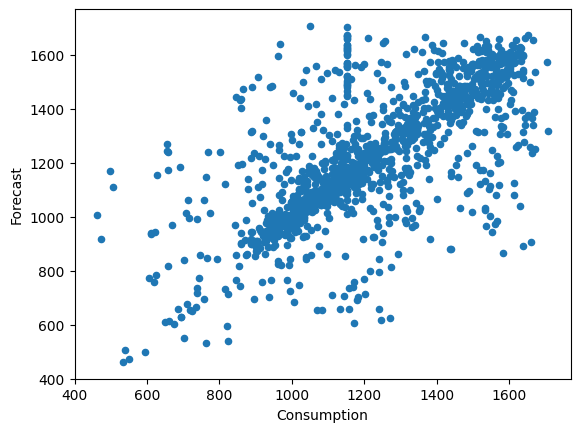

In [10]:
ax = pd.concat((y_test, forecast), axis=1).plot(x='Consumption',y='Forecast',kind='scatter')

# Create model

In [11]:
from sklearn.ensemble import GradientBoostingRegressor # type: ignore
# Split the dataset based on the cutoff date
cutoff_date = '2024-09-01 00:00:00'
train_data = df_hourly[df_hourly['ProductStartCET'] < cutoff_date].dropna(how='any')
test_data = df_hourly[df_hourly['ProductStartCET'] >= cutoff_date]


X_train = train_data[['ShiftedConsumption_168']]
X_test = test_data[['ShiftedConsumption_168']]
y_train = train_data['Consumption']
y_test = test_data['Consumption']


reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)
forecast = pd.Series(reg.predict(X_test), index=X_test.index, name='Forecast')

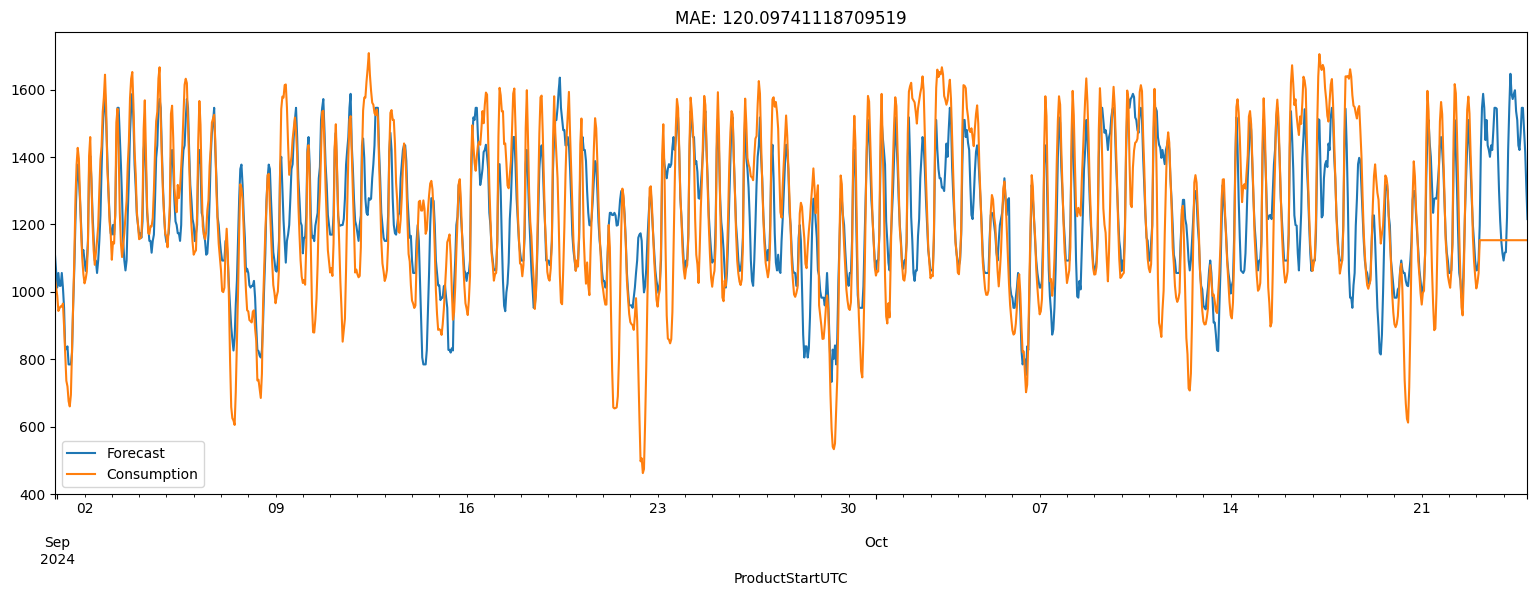

In [12]:
mae = (forecast - y_test).abs().mean()
forecast.plot(title='MAE: '+str(mae),figsize=(19, 6), legend=True)
ax = y_test.plot(title='MAE: '+str(mae),figsize=(19, 6), legend=True)

# Add new features

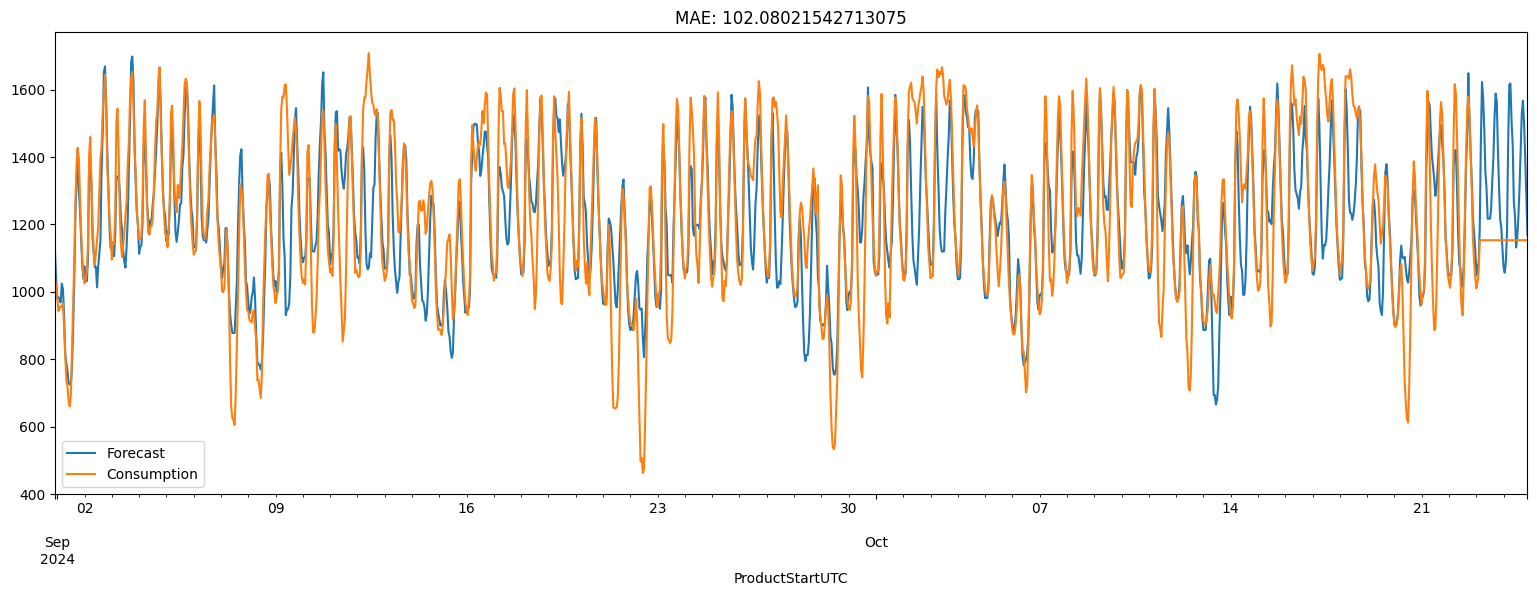

In [13]:
df_hourly['ShiftedConsumption_48'] = df_hourly['Consumption'].shift(48)
df_hourly['hour'] = df_hourly.index.hour
df_hourly['weekDay'] = df_hourly.index.weekday

cutoff_date = '2024-09-01 00:00:00'
train_data = df_hourly[df_hourly['ProductStartCET'] < cutoff_date].dropna(how='any')
test_data = df_hourly[df_hourly['ProductStartCET'] >= cutoff_date]


X_train = train_data[['ShiftedConsumption_168','hour','weekDay','ShiftedConsumption_48']]
X_test = test_data[['ShiftedConsumption_168','hour','weekDay','ShiftedConsumption_48']]
y_train = train_data['Consumption']
y_test = test_data['Consumption']


reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)
forecast = pd.Series(reg.predict(X_test), index=X_test.index, name='Forecast')


mae = (forecast - y_test).abs().mean()
forecast.plot(title='MAE: '+str(mae),figsize=(19, 6), legend=True)
ax = y_test.plot(title='MAE: '+str(mae),figsize=(19, 6), legend=True)

# Create forecast for tommorrow!

In [15]:
X_train

,ShiftedConsumption_168,hour,weekDay,ShiftedConsumption_48
ProductStartUTC,,,,
2023-01-07 23:00:00,836.0,23,5,1161.0
2023-01-08 00:00:00,829.0,0,6,1092.0
2023-01-08 01:00:00,794.0,1,6,1070.0
2023-01-08 02:00:00,760.0,2,6,1066.0
2023-01-08 03:00:00,739.0,3,6,1112.0
...,...,...,...,...
2024-10-24 17:00:00,1631.0,17,3,1579.0
2024-10-24 18:00:00,1559.0,18,3,1529.0
2024-10-24 19:00:00,1449.0,19,3,1409.0


In [16]:
y_train

ProductStartUTC
2023-01-07 23:00:00    1040.0
2023-01-08 00:00:00     997.0
2023-01-08 01:00:00     969.0
2023-01-08 02:00:00     955.0
2023-01-08 03:00:00     957.0
                        ...  
2024-10-24 17:00:00    1153.0
2024-10-24 18:00:00    1153.0
2024-10-24 19:00:00    1153.0
2024-10-24 20:00:00    1153.0
2024-10-24 21:00:00    1153.0
Freq: h, Name: Consumption, Length: 15743, dtype: float64

In [17]:
X_test

,ShiftedConsumption_168,hour,weekDay,ShiftedConsumption_48
ProductStartUTC,,,,


In [18]:
X_test.index

DatetimeIndex([], dtype='datetime64[ns]', name='ProductStartUTC', freq='h')

In [19]:
from datetime import datetime, timedelta
today_midnight = datetime.combine(datetime.today(), datetime.min.time())
cutoff_date=today_midnight + timedelta(days=1)
end_date=today_midnight + timedelta(days=2)

train_data = df_hourly[df_hourly['ProductStartCET'] < cutoff_date].dropna(how='any')
test_data = df_hourly[df_hourly['ProductStartCET'] >= cutoff_date]


X_train = train_data[['ShiftedConsumption_168','hour','weekDay','ShiftedConsumption_48']]
X_test = test_data[['ShiftedConsumption_168','hour','weekDay','ShiftedConsumption_48']]
y_train = train_data['Consumption']
y_test = test_data['Consumption']

reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)

result = test_data.copy()
result['Forecast'] = pd.Series(reg.predict(X_test), index = X_test.index, name='Forecast')

ValueError: Found array with 0 sample(s) (shape=(0, 4)) while a minimum of 1 is required by GradientBoostingRegressor.

In [20]:
#View how does forecast look like
result.plot(title='Consumption forecast',y='Forecast',x='ProductStartCET')
plt.ylabel('Consumption [MW]')
plt.show()

KeyError: 'Forecast'

In [21]:
#Change DateTime format
result=result[['ProductStartCET','Forecast']].copy()
result['ProductStartCET'] = result['ProductStartCET'].dt.strftime('%Y-%m-%dT%H:%M:%S')

KeyError: "['Forecast'] not in index"

In [15]:
#Save to csv without header
result.to_csv('output_file.csv', index=False, header=False,sep=',')
result

,ProductStartCET,Forecast
ProductStartUTC,,
2024-10-23 22:00:00,2024-10-24T00:00:00,1192.747457
2024-10-23 23:00:00,2024-10-24T01:00:00,1127.755159
2024-10-24 00:00:00,2024-10-24T02:00:00,1079.337533
2024-10-24 01:00:00,2024-10-24T03:00:00,1069.968503
2024-10-24 02:00:00,2024-10-24T04:00:00,1091.695982
2024-10-24 03:00:00,2024-10-24T05:00:00,1186.894465
2024-10-24 04:00:00,2024-10-24T06:00:00,1436.881725
2024-10-24 05:00:00,2024-10-24T07:00:00,1611.119081
2024-10-24 06:00:00,2024-10-24T08:00:00,1631.632471
